# Variance Reduction Techniques: Control and Antithetic Variates

Let the underlying asset price have the risk-neutral SDE,

$\frac{dS_t}{S_t}=(r-q)dt + \sigma dW_t$, where $W_t^{\mathbb{Q}}\sim N(0, t)$ is a $\mathbb{Q}\text{-Brownian Motion}$

An *Arithmetic Asian* option with maturity $T$ and strike $K$ has payoff:

$f_T=\left(\frac{1}{m}\sum_{i=1}^{m} S_{t_i}-K\right)^+$, where $t_i=iT/m$.

We want to evaluate the price of this option for $T=1\;,m=4,\;S_0=100,\;r=0.05,\;q=0.02,\;\sigma=0.2,$ in the strike space $K=90, 95, 100, 105, 110 ,115, 120$ using 3 methods:

1. **Standard Monte Carlo**

    First, we use the standard MC method to price the option contracts using $M=100$ sample paths. We generate 100 Standard MC estimators of the call price and store them in a $ 7\;\text{x} \;100$ array.


2. **Control Variates Monte Carlo**

    Next, we use the Control Variates method to price the option using $M=100$ sample paths. For the auxiliary payoff, we use the *Geometric Asian call option*, whose payoff at maturity depends on the Geometric Mean of the underlying asset price over the option period:
    
    $f_T=\left(\prod_{i=1}^mS_{t_i}-K\right)^+$, 
    
   for which there is an explicit closed-form expression for the expected value. Again, we generate 100 Control Variates estimators of the call price and store them in a $7\;\text{x} \;100$ array.
   
   For the *Geometric Asian Call*, the explicit closed-form solution is:
   
   $C_0^{\text{geom_asian}}=e^{-rT}\mathop{\mathbb{E}}^{\mathbb{Q}}(f_T)=e^{-rT}\left[FN(d_1)-KN(d_2)\right]=e^{-rT}BS_C(F, K, r=0, T, \hat{\sigma},q=0)$
   
   where $d_1=\frac{\ln(F/K)+\frac{\hat{\sigma}^2}{2}T}{\hat{\sigma}\sqrt{T}}$ and $d_2=d_1-\hat{\sigma}\sqrt{T}$, with $\hat{\sigma}^2=\frac{\sigma^2 m(m+1)(2m+1)}{6m^3}$ and $F=S_0e^{\left(r-q-\frac{\sigma^2}{2}\right)\frac{Tm(m+1)}{2m^2}+\frac{T\hat{\sigma}^2}{2}}$.
   
   To derive these formulas, notice that $F=S_0M_1$ and $\hat{\sigma}=\sqrt{\frac{\ln{(M_2/M_1^2)}}{T}}$, where
   
   $M_1=\mathbb{E}e^{\frac{1}{m}\sum_{i=1}^m\left(\left(r-q-\frac{\sigma^2}{2}\right)t_i+\sigma W_{t_i}\right)}$
   
      $=\mathbb{E}e^{\frac{1}{m}\left(\sum_{i=1}^m\left(r-q-\frac{\sigma^2}{2}\right)\frac{iT}{m}+\sum_{i=1}^m(m+1-i)(W_{t_i}-W_{t_{i-1}})\right)}$
      
      $=e^{\left(r-q-\frac{\sigma^2}{2}\right)\frac{T}{m^2}\sum_{i=1}^{m}i}\prod_{i=1}^{m}\mathbb{E}e^{\frac{\sigma_i}{m}\Delta W_i}$, $\Delta W_i\overset{iid}\sim N(0, \frac{T}{m})$
      
      $=e^{\left(r-q-\frac{\sigma^2}{2}\right)\frac{T}{m^2}\sum_{i=1}^{m}i+\frac{\sigma^2T}{2m^3}\sum_{i=1}^{m}i^2}$

    and 

    $M_2=\mathbb{E}e^{\frac{2}{m}\sum_{i=1}^m\left(\left(r-q-\frac{\sigma^2}{2}\right)t_i+\sigma W_{t_i}\right)}$
   
   $=\mathbb{E}e^{\frac{2}{m}\left(\sum_{i=1}^m\left(r-q-\frac{\sigma^2}{2}\right)\frac{iT}{m}+\sum_{i=1}^m(m+1-i)(W_{t_i}-W_{t_{i-1}})\right)}$
   
   $=e^{\left(r-q-\frac{\sigma^2}{2}\right)\frac{2T}{m^2}\sum_{i=1}^{m}i}\prod_{i=1}^{m}\mathbb{E}e^{\frac{2\sigma_i}{m}\Delta W_i}$
   
   $=e^{\left(r-q-\frac{\sigma^2}{2}\right)\frac{2T}{m^2}\sum_{i=1}^{m}i+\frac{2\sigma^2T}{m^3}\sum_{i=1}^{m}i^2}$

   Lastly, using the formulas $\sum_{i=1}^{m}i=\frac{m(m+1)}{2}$ and $\sum_{i=1}^{m}i=\frac{m(m+1)(2m+1)}{6}$ the explicit formulas for $F$ and $\hat{\sigma}^2$ given above will follow.




3. **Antithetic Sampling Monte Carlo**

    Latly, we use antithetic sampling to price the option contracts $\tilde{W}=-W$, using half of the Standard Monte Carlo sample paths $N=\frac{M}{2}=50$.

### Initial Parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

In [2]:
T = 1
m = 4
r = 0.05
q = 0.02
sigma = 0.2
S0 = 100
K = np.arange(90, 121, 5)
M = 100 # Number of Monte Carlo paths
ti = np.linspace(T / m, T, m)
dt = ti[1] - ti[0]
disc = exp(-r * T)

# 1. Standard Monte Carlo

In [3]:
# Empty list to store the (7 x 100) Standard Monte Carlo estimators of the Arithmetic Asian call price
standard_mc = []

# Compute 100 Standard MC Estimators of the Arithmetic Asian call price:
for i in range(100):

    # Sample a m x M Standard Brownian Motion
    B = np.random.normal(0, 1, (m, M)) * sqrt(dt)

    # Create the Brownian Motion paths across the m time nodes for all the M Monte Carlo paths
    W = np.cumsum(B, axis = 0)

    # Create the underlying asset paths using the Geometric Brownian Motion SDE
    S = S0 * np.exp((r - q - 0.5 * (sigma ** 2)) * ti.reshape(-1, 1) + sigma * W)

    # Compute the arithmetic average across the m time nodes for each Monte Carlo sample
    S_average = S.mean(axis = 0)

    # Create the Strikes x Terminal Price grid to price the option on the strike space
    [S_av, K_grid] = np.meshgrid(S_average, K)
    
    # Arithmetic Asian call payoffs at maturity
    final_payoffs = np.maximum(S_av - K_grid, 0)\
    
    # Price the option
    call_prices = disc * final_payoffs.mean(axis = 1)
    
    # Collect the Standard MC estimator
    standard_mc.append(call_prices)
    

In [4]:
# Transform the (7 x 100) Standard Monte Carlo estimators into a dataframe
standard_mc_df = pd.DataFrame(np.array(standard_mc).T, index=K)
standard_mc_df.index.rename("Strike", inplace=True)
standard_mc_df.round(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Strike,,,,,,,,,,,,,,,,,,,,,
90,13.79,12.36,14.23,12.39,11.89,11.68,11.33,11.22,11.46,13.79,...,12.70,11.42,12.98,11.04,13.01,13.15,10.82,14.73,12.82,10.65
95,9.92,8.83,10.72,8.99,8.65,8.18,8.07,7.90,8.11,10.33,...,8.93,8.09,9.34,7.96,9.56,9.64,7.55,10.81,9.47,7.18
100,6.68,5.87,7.61,6.34,5.96,5.57,5.38,5.18,5.45,7.28,...,5.88,5.27,6.50,5.62,6.76,6.82,5.11,7.83,6.66,4.64
105,4.27,3.65,5.13,4.30,3.88,3.68,3.28,3.20,3.48,4.84,...,3.56,3.22,4.20,3.73,4.64,4.51,3.29,5.48,4.38,2.86
110,2.46,2.13,3.35,2.79,2.34,2.31,1.80,1.76,2.24,3.11,...,1.99,1.98,2.56,2.26,3.01,2.77,1.99,3.67,2.63,1.68
115,1.34,1.17,2.05,1.75,1.25,1.38,0.98,0.85,1.31,1.86,...,0.94,1.23,1.42,1.19,1.58,1.70,1.17,2.11,1.59,1.11
120,0.66,0.63,1.12,1.13,0.69,0.83,0.57,0.44,0.83,1.01,...,0.26,0.86,0.75,0.65,0.64,0.93,0.63,1.11,0.85,0.80


# 2. Control Variates Monte Carlo

The Control Variates method reduces the variance of a Monte Carlo estimator by using another random variable with a known expectation, which is correlated with the random variable whose expectation needs to be estimated.

Let $Y$ be a random variable (option payoff at expiry T) and suppose that we want to estimate $\theta=\mathbb{E}Y$. The standard Monte Carlo estimator is $\hat{\theta}=\frac{1}{N}\sum_{i=1}^{N}Y_i$.

If there exists another random variable $Z$ with a **known** expectation $\mathbb{E}Z$, then, we can construct the **Control Variates estimator** as $\hat{\theta}_{CV}=\hat{\theta}-b\left[\bar{Z}-\mathbb{E}Z\right]\implies\bar{Y}_{CV}=\bar{Y}-b\left[\bar{Z}-\mathbb{E}Z\right]\;\text{or}\;Y_{CV}=Y-b\left[Z-\mathbb{E}Z\right]$.

At each simulation\path we simualate $Y_{CV_i}=Y_i-b\left[Z_i-\mathbb{E}Z\right]$

This estimator is unbiased, since $\mathbb{E}\bar{Y}_{CV}=\mathbb{E}\bar{Y}-b\left[\mathbb{E}\bar{Z}-\mathbb{E}Z\right]=\mathbb{E}\bar{Y}=\theta$

Also, notice that $Var(Y_{CV})=Var(Y)-2bCov(Y, Z) + b^2Var(Z)$. It can easily be shown that this variance is minimized when we let $b=\frac{Cov(Y, Z)}{Var(Z)}=\rho_{YZ}\frac{\sigma_Y}{\sigma_Z}$. Because $Cov(Y, Z)$ is unknown we estimate $\beta$ using the sample moments.

Then, $Var(Y_{CV})=(1-\rho_{YZ}^2)Var(Y)\leq Var(Y)$ which offers the desired variance reduction in the new estimator.

Therefore, as$|\rho_{(YZ)}|\uparrow\;\;Var(Y_{CV})\downarrow$

Here, in each simulation path we let:

$Y_i=\text{Discounted payoff of Arithmetic Asian option at }t_0\;\text{,and }Z_i=\text{Discounted payoff of Geometric Asian option at }t_0$

Note that we could also use the payoff of a plain European option as the control variate.

In [5]:
from scipy.stats import gmean
from py_vollib_vectorized.models import vectorized_black_scholes_merton as bs

In [6]:
# Let Psi_i be the discounted payoff of the Arithmetic Asian option, we use the Arithmetic Asian payoffs
# computed in the previous cell
Y = disc * final_payoffs

# Compute the Geometric Average across the m time nodes for each Monte Carlo sample
S_average_geo = gmean(S, axis=0)

# Create the Strike x Terminal Price grid to price the options on the strike space
[S_av_geo, K_grid ] = np.meshgrid(S_average_geo, K)

# Final payoffs
final_payoffs_geo = np.maximum(S_av_geo - K_grid, 0)

# Let Z_i be the discounted payoff of the Geometrix Asian option
Z = disc * final_payoffs_geo

# Compute the moments M1, M2 used in the BS-formula to calculate the Expected Value of Z
M1 = np.exp(0.5 * (T / m) * np.sum((sigma * (np.arange(1, m+1)) / m) ** 2))
M1 = np.exp((r - q - 0.5 * sigma ** 2) * np.mean(ti)) * M1

M2 = np.exp(0.5 * (T / m) * np.sum((2 * sigma * (np.arange(1, m+1)) / m) ** 2))
M2 = np.exp(2 * (r - q - 0.5 * sigma ** 2) * np.mean(ti)) * M2

# Given M1, M2, compute the BS input parameters to calculate the Expected Value of the Geometric Asian option
F = S0 * M1
sigma_hat = sqrt(log(M2) - 2 * log(M1)) / sqrt(T)

# Compute the Expected Values of the Geometric Asian option
EZ = disc * (bs("c", F, K, T, 0, sigma_hat, 0).values.flatten())

# Compute the beta coefficients (7 x 1)
b = []

for i in range(Z.shape[0]):
    cov_matrix = np.cov(Z[i, :], Y[i, :])
    beta = cov_matrix[0, 1] / cov_matrix[0, 0]
    b.append(beta)
    
b = np.array(b).reshape(-1, 1)

# Compute the (7 x M) Control Variates: 1000 Monte Carlo values for each strike
Y_cv = Y - b *(Z - EZ.reshape(-1, 1))

# Compute the Control Variates estimator of the Expected Value 
call_prices_cv = Y_cv.mean(axis=1)

### Construct 100 Control Variates MC estimators

Now, we construct 100 Control Variates MC estimators and store them in $7\;\text{x }100$ array-100 Control Variates Estimators per Strike.

In [7]:
# Empty list to store the (7 x 100) Control Variates Monte Carlo estimators of the Arithmetic Asian call price
control_variates_mc = []

# Compute 100 Control Variates MC Estimators of the Arithmetic Asian call price:
for i in range(100):
    
    """First, we compute the Arithmetic Asian option payoff at maturity, which will be the Y variate
       because it does not have a closed-form expression for its expected value.
       
    """
    # Sample a m x M Standard Brownian Motion
    B = np.random.normal(0, 1, (m, M)) * sqrt(dt)

    # Create the Brownian Motion paths across the m time nodes for all the M Monte Carlo paths
    W = np.cumsum(B, axis = 0)

    # Create the underlying asset paths using the Geometric Brownian Motion SDE
    S = S0 * np.exp((r - q - 0.5 * (sigma ** 2)) * ti.reshape(-1, 1) + sigma * W)

    # Compute the arithmetic average across the m time nodes for each Monte Carlo sample
    S_average = S.mean(axis = 0)

    # Create the Strikes x Terminal Price grid to price the option on the strike space
    [S_av, K_grid] = np.meshgrid(S_average, K)
    
    # Arithmetic Asian payoffs at matuirty
    final_payoffs_arithmetic = np.maximum(S_av - K_grid, 0)
    
    
    """Next, we compute the Geometric Asian payoff at matuirty, which will be the Z variate 
       because it has a closed-form expression for the expected value.
    
    """
    
    # Let Y_i be the discounted payoff of the Arithmetic Asian option
    Y = disc * final_payoffs_arithmetic

    # Compute the Geometric Average across the m time nodes for each Monte Carlo sample
    S_average_geo = gmean(S, axis=0)

    # Create the Strike x Terminal Price grid to price the options on the strike space
    [S_av_geo, K_grid ] = np.meshgrid(S_average_geo, K)

    # Final payoffs of the Geometric Asian Call
    final_payoffs_geo = np.maximum(S_av_geo - K_grid, 0)

    # Let Z_i be the discounted payoff of the Geometric Asian option
    Z = disc * final_payoffs_geo

    # Compute the moments M1, M2 used in the BS-formula to calculate the Expected Value of Z
    M1 = np.exp(0.5 * (T / m) * np.sum((sigma * (np.arange(1, m+1)) / m) ** 2))
    M1 = np.exp((r - q - 0.5 * sigma ** 2) * np.mean(ti)) * M1

    M2 = np.exp(0.5 * (T / m) * np.sum((2 * sigma * (np.arange(1, m+1)) / m) ** 2))
    M2 = np.exp(2 * (r - q - 0.5 * sigma ** 2) * np.mean(ti)) * M2

    # Given M1, M2, compute the BS input parameters to calculate the Expected Value of the Geometric Asian option
    F = S0 * M1
    sigma_hat = sqrt(log(M2) - 2 * log(M1)) / sqrt(T)

    # Compute the Expected Values of the Geometric Asian option
    EZ = disc * (bs("c", F, K, T, 0, sigma_hat, 0).values.flatten())

    # Compute the beta coefficients (7 x 1)
    b = []
    
    for j in range(Z.shape[0]):
        cov_matrix = np.cov(Z[j, :], Y[j, :])
        beta = cov_matrix[0, 1] / cov_matrix[0, 0]
        b.append(beta)
    
    b = np.array(b).reshape(-1, 1)

    # Compute the (7 x M) Control Variates: M Monte Carlo values for each strike
    Y_cv = Y - b *(Z - EZ.reshape(-1, 1))

    # Compute the Control Variates estimator of the Expected Value 
    call_prices_cv = Y_cv.mean(axis=1)
    
    # Collect the Control Variates estimator
    control_variates_mc.append(call_prices_cv)

In [8]:
# Transform the (7 x 100) Control Variates MC estimators into a dataframe
control_variates_mc_df = pd.DataFrame(np.array(control_variates_mc).T, index=K)
control_variates_mc_df.index.rename("Strike", inplace=True)
control_variates_mc_df.round(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Strike,,,,,,,,,,,,,,,,,,,,,
90,12.57,12.51,12.56,12.48,12.53,12.53,12.54,12.53,12.57,12.56,...,12.54,12.54,12.51,12.53,12.58,12.55,12.54,12.53,12.49,12.49
95,9.08,9.02,9.07,8.99,9.03,9.03,9.04,9.03,9.05,9.06,...,9.01,9.05,9.02,9.03,9.08,9.06,9.05,9.00,9.00,8.99
100,6.20,6.20,6.23,6.15,6.19,6.17,6.21,6.20,6.19,6.22,...,6.18,6.20,6.18,6.19,6.24,6.23,6.21,6.17,6.17,6.16
105,4.06,4.04,4.08,4.00,4.03,4.02,4.04,4.06,4.03,4.06,...,4.02,4.05,4.05,4.04,4.07,4.07,4.05,4.02,4.01,4.01
110,2.52,2.53,2.54,2.48,2.49,2.50,2.50,2.55,2.50,2.53,...,2.49,2.54,2.50,2.52,2.54,2.54,2.51,2.51,2.50,2.49
115,1.51,1.50,1.52,1.48,1.47,1.48,1.48,1.50,1.49,1.51,...,1.48,1.52,1.47,1.48,1.51,1.52,1.48,1.48,1.47,1.46
120,0.83,0.85,0.88,0.85,0.84,0.86,0.85,0.86,0.86,0.86,...,0.83,0.89,0.83,0.84,0.86,0.86,0.82,0.85,0.83,0.83


# 3. Antithetic Variates

The Antithetic Variates method reduces the variance of a Monte Carlo estimator by inducing explicitly negative dependence between pairs of samples.


As before, we want to estimate $\theta=\mathbb{E}Y$. Suppose we sample a pair ($Y,Y^*$) and then define the estimator $\hat{\theta}=\frac{1}{2}(Y+Y^*)$. Then,$Var(\hat{\theta})=\frac{1}{4N}\left[Var(Y)+Var(Y^*)+2Cov(Y, Y^*)\right]$. If $Cov(Y, Y^*)<0$ we can achieve the desired reduction in the variance of the estimator. 

Typically, we accomplish $Cov(Y, Y^*)<0$ by explicitly inducing negative dependence in the samples of Y:

1. If we use the Inverse CDF sampling method, we can sample $Y=F^{-1}(U)\;\text{and}\;Y^*=F^{-1}(1-U)$ since both are Unifrom random variables and perfectly negative correlated.

2. If we are sampling from a symmetric distribution $\left(P\left(X\leq \alpha\right)=P\left(X\geq -\alpha\right)\right)$ like the Normal, we can simply invert the signs of the samples to generate two perfectly negative correlated samples.

For instance, if $X_i\sim N(\mu, \sigma^2)\;\text{then we can take}\;Y_i=f(X_i)\;\text{and }Y_i^*=f(-X_i)$. While the pricing function $f(X)$ will reduce the effects of the negative covariance between the samples, typically it will preserve some of them.

The *Standard MC estimator* is $\hat{\theta}=\frac{1}{2N}\sum_{i=1}^{2N}Y_i\;\text{with } Var(\hat{\theta})=\frac{1}{2N}Var(Y)$.

The *Antithetic Variates MC estimator* is constructed as:

Draw samples $\{Y_i, Y_i^*\}\;\text{for }i=1:N$ and define the random variable $Y_i^{\alpha}=\frac{1}{2}\left(Y_i+Y_i^*\right)$.

The *Antithetic Variates MC estimator* is $\hat{\theta^{\alpha}}=\frac{1}{N}\sum_{i=1}^{N}Y_i^{\alpha}$ and if $\mathbb{E}Y_i=\mathbb{E}Y_i^{\alpha}=\mu_{Y},\;\hat{\theta^{\alpha}}\;\text{is an unbiased estimator }\mathbb{E}\hat{\theta^{\alpha}}=\mu_{Y}$, with variance $Var(\hat{\theta^{\alpha}})=\frac{1}{N}Var(Y_i^{\alpha})=\frac{1}{4N}\left[Var(Y_i)+Var(Y_i^*) +2Cov(Y_i, Y_i^*)\right]$.

In [9]:
# Draw a (m, N) Standard Brownian Motion with N = M / 2, (Half the samples of the Standard Monte Carlo)
N = int(M / 2)
B = np.random.normal(0, 1, (m, N)) * sqrt(dt)

# Create the Brownian Motion path across the m time nodes for all the MC samples.
W = np.cumsum(B, axis = 0)

""" First, we compute the Original Samples of the call price"""

# Create the underlying asset paths-These will be the Original samples
S = S0 * np.exp((r - q - 0.5 * (sigma ** 2)) * ti.reshape(-1, 1) + sigma * W)

# Compute the Average underlying asset price across the m time nodes for all the MC samples
S_average = S.mean(axis = 0)

# Create the Strike x Terminal Price space
[S_av, K_grid] = np.meshgrid(S_average, K)

# Compute the Original final payoffs
final_payoffs_orig = np.maximum(S_av - K_grid, 0)

# Create the Monte Carlo option values - These are the Original variables Yi
Yi = disc * final_payoffs_orig




"""Next, we compute the Antithetic Samples of the call price"""

# Create the Antithetic Sample by reversing the sign of the Normal random variable W- These will be the Antithetic samples.
S_anti = S0 * np.exp((r - q - 0.5 * (sigma ** 2)) * ti.reshape(-1, 1) + sigma * (- W))

# Compute the Average of the Antithetic underlying asset price across the m time nodes for all the MC samples
S_average_anti = S_anti.mean(axis = 0)

# Create the Strike x Terminal Price space
[S_av_anti, K_grid] = np.meshgrid(S_average_anti, K)

# Compute the Antithetic final payoffs
final_payoffs_anti = np.maximum(S_av_anti - K_grid, 0)

# Create the Monte Carlo option values - These are the Antithetic variables Yi*
Yi_star = disc * final_payoffs_anti

# Create the Antithetic samples Ya of the Monte Carlo option prices
Yi_anti = 0.5 * (Yi + Yi_star)

# Compute the Antithetic Monte Carlo estimator of the option price-Mean of the Antithetic Samples
call_prices_anti = Yi_anti.mean(axis = 1)

### Construct 100 Control Variates MC estimators

Now, we construct 100 Antithetic Variates MC estimators and store them in $7\;\text{x }100$ array-100 Control Variates Estimators per Strike.

In [10]:
# Empty list to store the (7 x 100) Antithetic Variates Monte Carlo estimators of the Arithmetic Asian call price
antithetic_variates_mc = []

# Compute 100 Antithetic Variates MC Estimators of the Arithmetic Asian call price:  
    
for i in range(100):
    
    # Draw a (m, N) Standard Brownian Motion with N = M / 2, (Half the samples of the Standard Monte Carlo)
    N = int(M / 2)
    B = np.random.normal(0, 1, (m, N)) * sqrt(dt)

    # Create the Brownian Motion path across the m time nodes for all the MC samples.
    W = np.cumsum(B, axis = 0)

    """ First, we compute the Original Samples of the call price"""

    # Create the underlying asset paths-These will be the Original samples
    S = S0 * np.exp((r - q - 0.5 * (sigma ** 2)) * ti.reshape(-1, 1) + sigma * W)

    # Compute the Average underlying asset price across the m time nodes for all the MC samples
    S_average = S.mean(axis = 0)

    # Create the Strike x Terminal Price space
    [S_av, K_grid] = np.meshgrid(S_average, K)

    # Compute the Original final payoffs
    final_payoffs_orig = np.maximum(S_av - K_grid, 0)

    # Create the Monte Carlo option values - These are the Original variables Yi
    Yi = disc * final_payoffs_orig




    """Next, we compute the Antithetic Samples of the call price"""

    # Create the Antithetic Sample by reversing the sign of the Normal random variable W- These will be the Antithetic samples.
    S_anti = S0 * np.exp((r - q - 0.5 * (sigma ** 2)) * ti.reshape(-1, 1) + sigma * (- W))

    # Compute the Average of the Antithetic underlying asset price across the m time nodes for all the MC samples
    S_average_anti = S_anti.mean(axis = 0)

    # Create the Strike x Terminal Price space
    [S_av_anti, K_grid] = np.meshgrid(S_average_anti, K)

    # Compute the Antithetic final payoffs
    final_payoffs_anti = np.maximum(S_av_anti - K_grid, 0)

    # Create the Monte Carlo option values - These are the Antithetic variables Yi*
    Yi_star = disc * final_payoffs_anti

    # Create the Antithetic samples Ya of the Monte Carlo option prices
    Yi_anti = 0.5 * (Yi + Yi_star)

    # Compute the Antithetic Monte Carlo estimator of the option price-Mean of the Antithetic Samples
    call_prices_anti = Yi_anti.mean(axis = 1)
    
    # Collect the antithetic variates estimators
    antithetic_variates_mc.append(call_prices_anti)

In [11]:
antithetic_variates_mc_df = pd.DataFrame(np.array(antithetic_variates_mc).T, index=K)
antithetic_variates_mc_df.index.rename("Strike", inplace=True)
antithetic_variates_mc_df.round(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Strike,,,,,,,,,,,,,,,,,,,,,
90,13.90,12.53,11.82,12.55,12.62,11.45,12.85,12.18,12.40,12.11,...,12.36,12.39,12.18,12.74,12.60,12.78,12.47,13.27,13.17,12.76
95,10.40,8.89,8.14,8.97,9.04,7.73,9.51,8.58,8.98,8.53,...,8.78,8.72,8.57,9.45,8.95,9.33,8.83,9.84,9.83,9.19
100,7.47,5.91,5.25,6.30,6.12,4.72,6.80,5.75,6.13,5.73,...,5.86,5.91,5.72,6.79,6.18,6.45,5.83,7.13,7.07,6.21
105,5.39,3.85,3.07,4.05,3.97,2.71,4.53,3.58,3.98,3.54,...,3.77,3.73,3.56,4.54,3.99,4.32,3.80,4.88,4.89,4.14
110,3.86,2.49,1.69,2.47,2.57,1.37,2.88,2.13,2.42,2.07,...,2.27,2.27,2.05,2.79,2.56,2.79,2.37,3.25,3.21,2.69
115,2.82,1.51,0.81,1.54,1.61,0.60,1.63,1.18,1.34,1.09,...,1.31,1.37,1.20,1.54,1.64,1.69,1.49,2.18,2.00,1.72
120,2.03,0.79,0.29,0.81,1.02,0.29,0.96,0.65,0.68,0.46,...,0.72,0.77,0.75,0.81,0.94,0.96,0.89,1.33,1.26,1.01


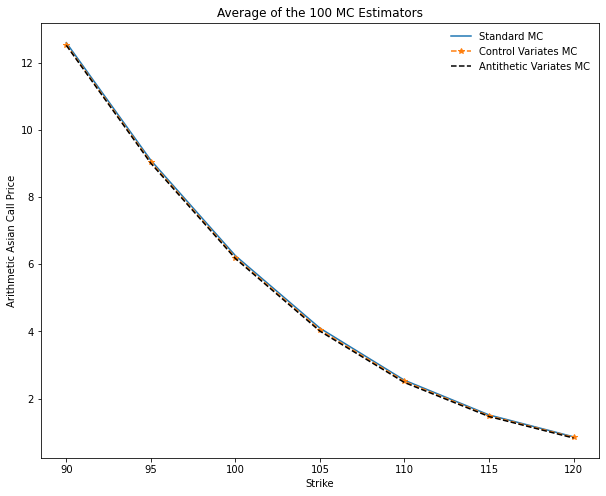

In [12]:
standard_mc_df.mean(axis = 1).plot(figsize=(10, 8), label="Standard MC")
control_variates_mc_df.mean(axis = 1).plot(linestyle="--", marker="*", label="Control Variates MC")
antithetic_variates_mc_df.mean(axis=1).plot(color="black", linestyle="--", label="Antithetic Variates MC")
plt.legend(frameon=False)
xticks = plt.xticks()[0]
plt.xlabel("Strike")
plt.ylabel("Arithmetic Asian Call Price")
plt.title("Average of the 100 MC Estimators")
plt.show()

# Standard Error of the MC Estimators across the 3 methods

In [13]:
# Extract the standard errors  of the 100 MC estimators of each method
std_standard_mc = standard_mc_df.std(axis = 1).rename("Std Standard MC")
std_control_variates_mc = control_variates_mc_df.std(axis = 1).rename("Std Control Variates MC")
std_antithetic_variates_mc = antithetic_variates_mc_df.std(axis = 1).rename("Std Antithetic MC")
moneyness = (S0 - K) / K

# Collect the Standard Errors in a dataframe
std = pd.concat([std_standard_mc, std_control_variates_mc, std_antithetic_variates_mc], axis=1).round(4)
std.set_index(moneyness.round(3), inplace=True)
std.index.rename("Moneyness", inplace=True)

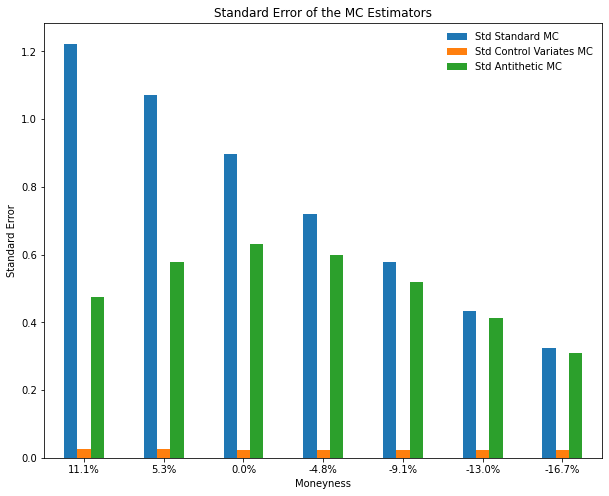

In [14]:
# Plot the Standard Errors
std.plot(kind="bar", figsize=(10, 8), rot=0)
xlabs = [str(100 * float(tick.get_text())) + "%" for tick in plt.xticks()[1]]
plt.xticks(ticks = plt.xticks()[0], labels=xlabs)
plt.xlabel("Moneyness")
plt.ylabel("Standard Error")
plt.title("Standard Error of the MC Estimators")
plt.legend(frameon=False)
plt.show()

In [15]:
std

,Std Standard MC,Std Control Variates MC,Std Antithetic MC
Moneyness,,,
0.111,1.2225,0.0248,0.4753
0.053,1.0695,0.0246,0.5771
0.000,0.8956,0.0237,0.6299
-0.048,0.7193,0.0226,0.5993
-0.091,0.5786,0.0224,0.5185
-0.130,0.4339,0.0222,0.4118
-0.167,0.3239,0.0240,0.3087


### Variance Reduction Techniques conclusion:

Control variates is clearly the best method for reducing error. As we move from ITM to OTM, the
Antithetic Variates method has less advantage over standard MC (i.e., Standard MC and
Antithetic Variates have roughly the equal error for OTM options). However,
for values of K that are deeper OTM, we see that Standard MC and Antithetic
Variates see a decrease in error, while Control Variates sees no decrease. Thus, the advantage
of using Control Variates is less for OTM options (A similar pattern exists when we price Arithmetic Asian options using European calls as the Control Variate).